1.TimeSerise

In [1]:
#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-visualization-with-python-3
#This tutorial will require the warnings, itertools, pandas, numpy, matplotlib and statsmodels libraries. The warnings and itertools libraries come included with the standard Python library set so you shouldn’t need to install them.
import nbconvert
nbconvert.NotebookExporter.output_mimetype = 'application/x-ipynb+json'

import warnings
warnings.filterwarnings(action='ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# fivethirtyeigh https://github.com/matplotlib/matplotlib/blob/38be7aeaaac3691560aeadafe46722dda427ef47/lib/matplotlib/mpl-data/stylelib/fivethirtyeight.mplstyle

In [2]:
import matplotlib.style as style
style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [3]:
#We’ll be working with a dataset called “Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.,” which collected CO2 samples from March 1958 to December 2001. We can bring in this data as follows:
#statsmodels/datasets/co2/data.py
data = sm.datasets.co2.load_pandas()
y = data.data

In [4]:
print(y.head(3))
print(y.tail(3))

              co2
1958-03-29  316.1
1958-04-05  317.3
1958-04-12  317.6
              co2
2001-12-15  371.2
2001-12-22  371.3
2001-12-29  371.5


In [5]:
#that will reveal missing data
y.isnull().sum()

co2    59
dtype: int64

In [6]:
y.describe()

,co2
count,2225.000000
mean,340.142247
std,17.003885
min,313.000000
25%,324.800000
50%,338.300000
75%,354.800000
max,373.900000


In [7]:
#The dtype=datetime[ns] field confirms that our index is made of date stamp objects, while length=2284 and freq='W-SAT' tells us that we have 2,284 weekly date stamps starting on Saturdays.
y.index

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19',
               '1958-04-26', '1958-05-03', '1958-05-10', '1958-05-17',
               '1958-05-24', '1958-05-31',
               ...
               '2001-10-27', '2001-11-03', '2001-11-10', '2001-11-17',
               '2001-11-24', '2001-12-01', '2001-12-08', '2001-12-15',
               '2001-12-22', '2001-12-29'],
              dtype='datetime64[ns]', length=2284, freq='W-SAT')

In [8]:
y.dtypes

co2    float64
dtype: object

In [9]:
#Weekly data can be tricky to work with, so let’s use the monthly averages of our time-series instead. This can be obtained by using the convenient resample function, which allows us to group the time-series into buckets (1 month), apply a function on each group (mean), and combine the result (one row per group).
# The 'MS' string groups the data in buckets by start of the month
# resample function, which allows us to group the time-series into buckets (1 month)
y = y['co2'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
# pandas using the fillna()
y = y.fillna(y.bfill())

print(y)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64


In [10]:
y.isnull().sum()

0

In [11]:
#pandas is its ability to handle date stamp indices, which allow us to quickly slice our data
y['2001':]

2001-01-01    370.175
2001-02-01    371.325
2001-03-01    372.060
2001-04-01    372.775
2001-05-01    373.800
2001-06-01    373.060
2001-07-01    371.300
2001-08-01    369.425
2001-09-01    367.880
2001-10-01    368.050
2001-11-01    369.375
2001-12-01    371.020
Freq: MS, Name: co2, dtype: float64

In [12]:
#Or, we can slice our dataset to only retrieve data points between October 1995 and October 1996:
y['1995-01-01':'1996-01-01']

1995-01-01    359.975
1995-02-01    360.925
1995-03-01    361.575
1995-04-01    363.360
1995-05-01    363.700
1995-06-01    363.250
1995-07-01    361.800
1995-08-01    359.375
1995-09-01    358.000
1995-10-01    357.850
1995-11-01    359.475
1995-12-01    360.700
1996-01-01    362.025
Freq: MS, Name: co2, dtype: float64

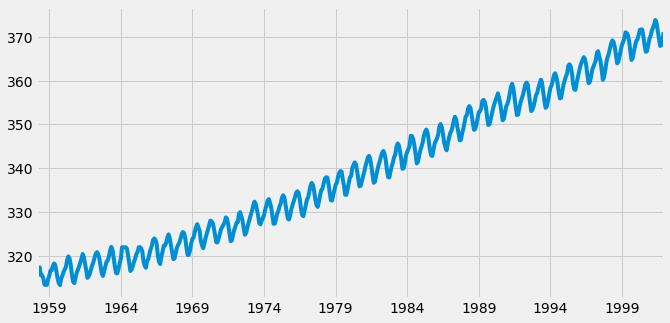

In [13]:
# Visualizing Time-series Data, pandas wrapper around the matplotlib API to display a plot of our dataset
#Some distinguishable patterns appear when we plot the data. The time-series has an obvious seasonality pattern, as well as an overall increasing trend. We can also visualize our data using a method called time-series decomposition. As its name suggests, time series decomposition allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

y.plot(figsize=(10, 5))
plt.show()


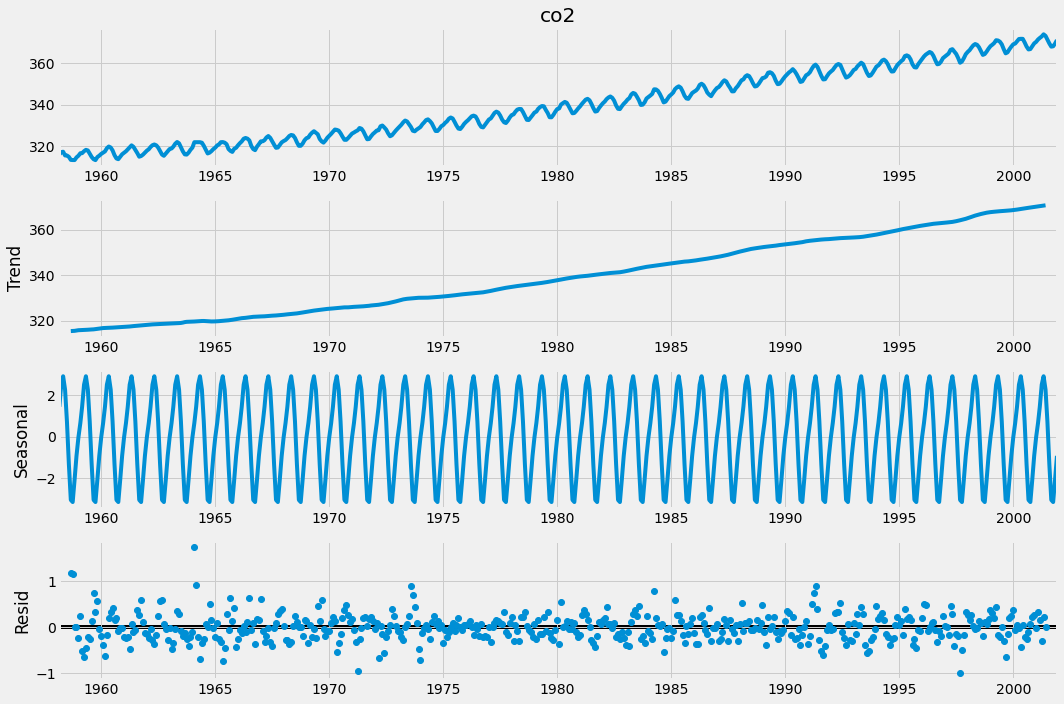

In [14]:
#Fortunately, statsmodels provides the convenient seasonal_decompose function to perform seasonal decomposition out of the box. If you are interested in learning more, the reference for its original implementation can be found in the following paper, “STL: A Seasonal-Trend Decomposition Procedure Based on Loess.”
#seasonality: does the data display a clear periodic pattern?
#trend: does the data follow a consistent upwards or downward slope?
#noise: are there any outlier points or missing values that are not consistent with the rest of the data?
 
#PyLab is a procedural interface to the Matplotlib object-oriented plotting library. ... PyLab is a convenience module that bulk imports matplotlib. pyplot (for plotting) and NumPy (for Mathematics and working with arrays) in a single name space.
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

2.Seasonal ARIMA(Autoregressive integrated moving average)

In [15]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue
            

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624047479
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.8282341411875
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.711172764114
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320026


/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878941836889
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578978063383
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647902767849
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048754139252
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327424764
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941067417824
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716866
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:800.4739593443599


/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:842.0237570327606
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893594518
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912987044778
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1675.8086923024293
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.221119919409
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:633.4425587121109
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:337.7938543914877
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:619.9501759067808
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:376.9283764697746
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:478.3296906912168
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:323.07765079955044
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1371.1872602337235
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1101.84107343021
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:587.9479710310301
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:302.4949000973605
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:584.433353375639
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:337.19990420420663
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:433.0863608186126
ARIMA(0

/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1676.8881767362054


/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1241.9354486489597
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:624.260235261962
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:341.2896601644097


/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:579.3897693747157
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:370.5918648223041
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:476.0500429535656
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:327.58085982293653


/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1372.6085881744507
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1199.4888128449325
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:586.4485734367357
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:305.6273826746159


/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:587.4296098897366


/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:398.60997568424534
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:433.546946437012
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:284.3596769137276
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1324.3111127324569
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1060.935191442614
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:600.741268316551
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:312.1329630743286
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:593.6637755544133
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:349.2091452960266
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:440.1375881909207
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:293.74262244601886
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1262.6545542464767
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1052.0636724060996
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:581.3099946418222
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:295.9374061715689
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:576.864711600356
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:327.9049014123218
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:428.6024636634236
ARIMA(1,

In [16]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.441      0.001       0.137       0.499
ma.L1         -0.6253      0.077     -8.159      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.730      0.084      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.832      0.000      -0.928      -0.826
sigma2         0.0971      0.004     22.639      0.000       0.089       0.106


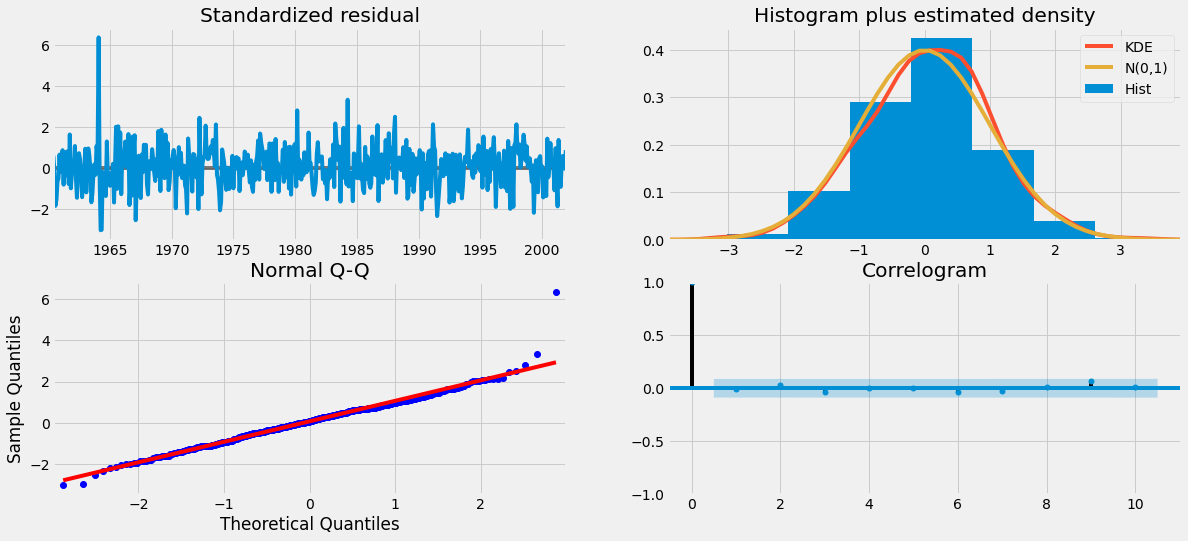

In [30]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

3.Predict 

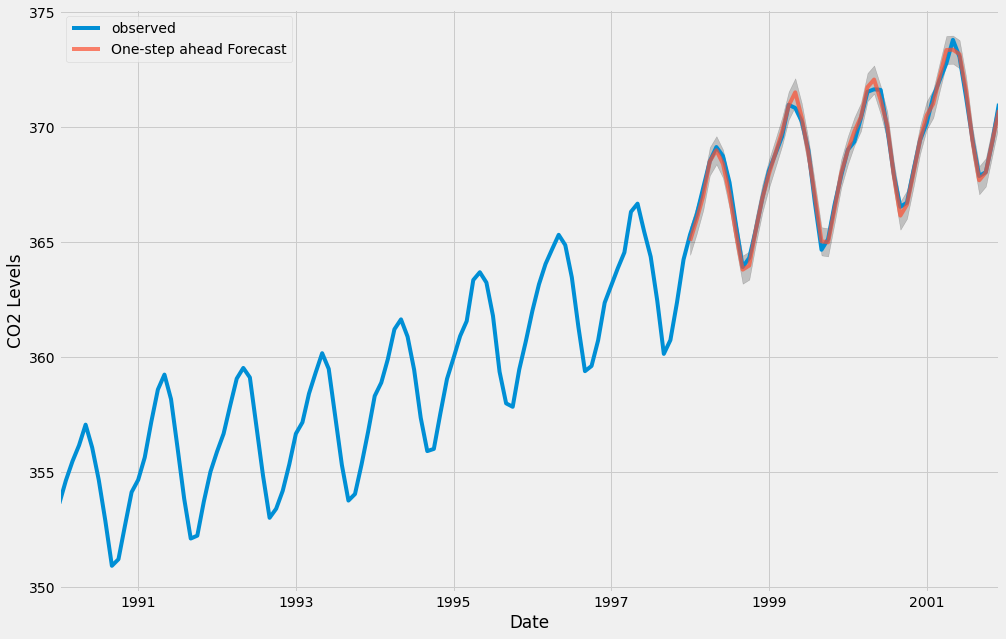

In [26]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

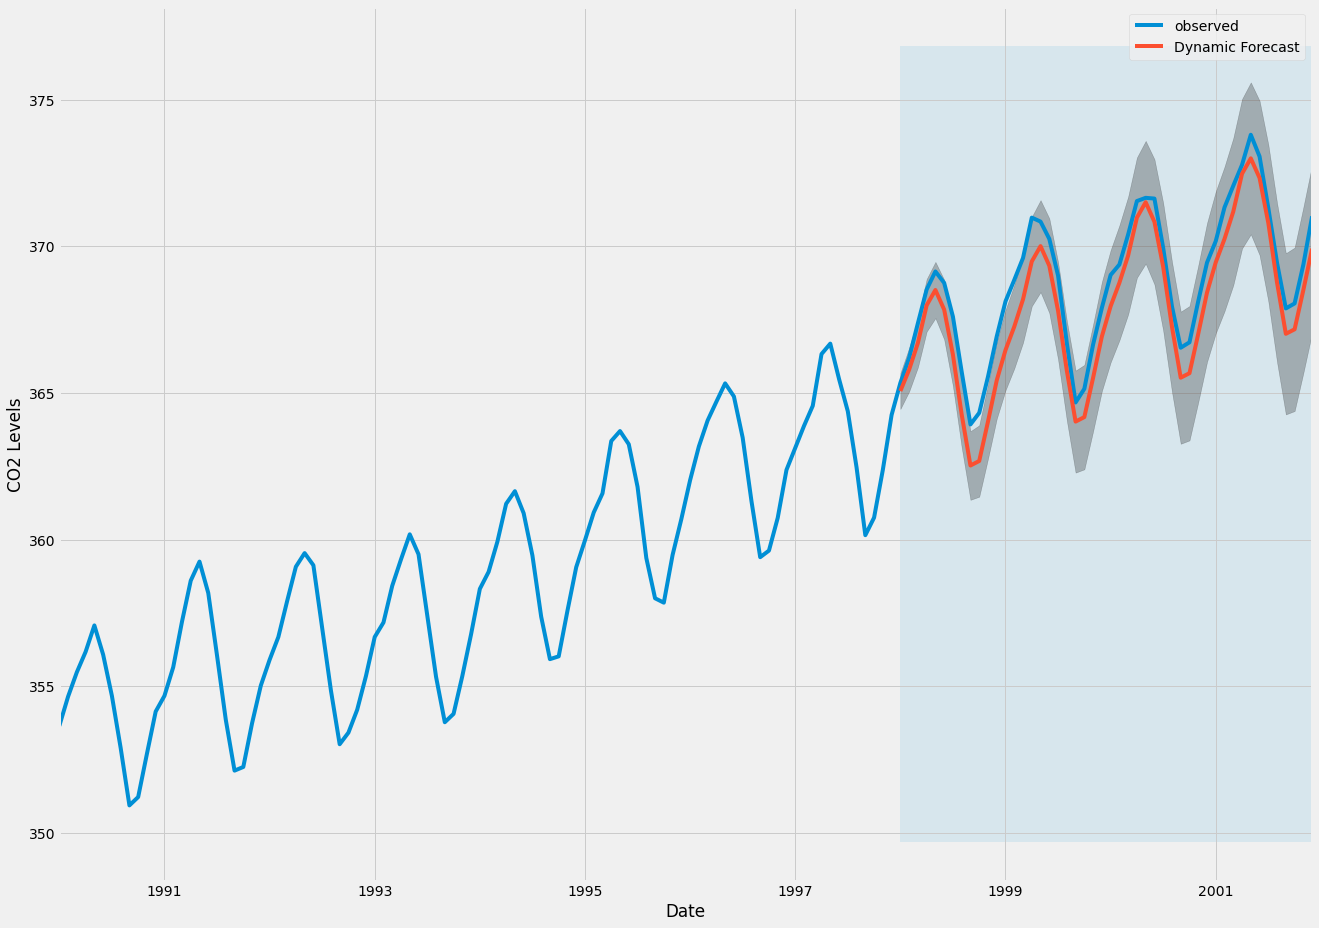

In [27]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [28]:
#Obs: In both MSE and RMSE, values closer to zero are better. They are a measure of accuracy.

y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


In [29]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
 


The Mean Squared Error of our forecasts is 1.01


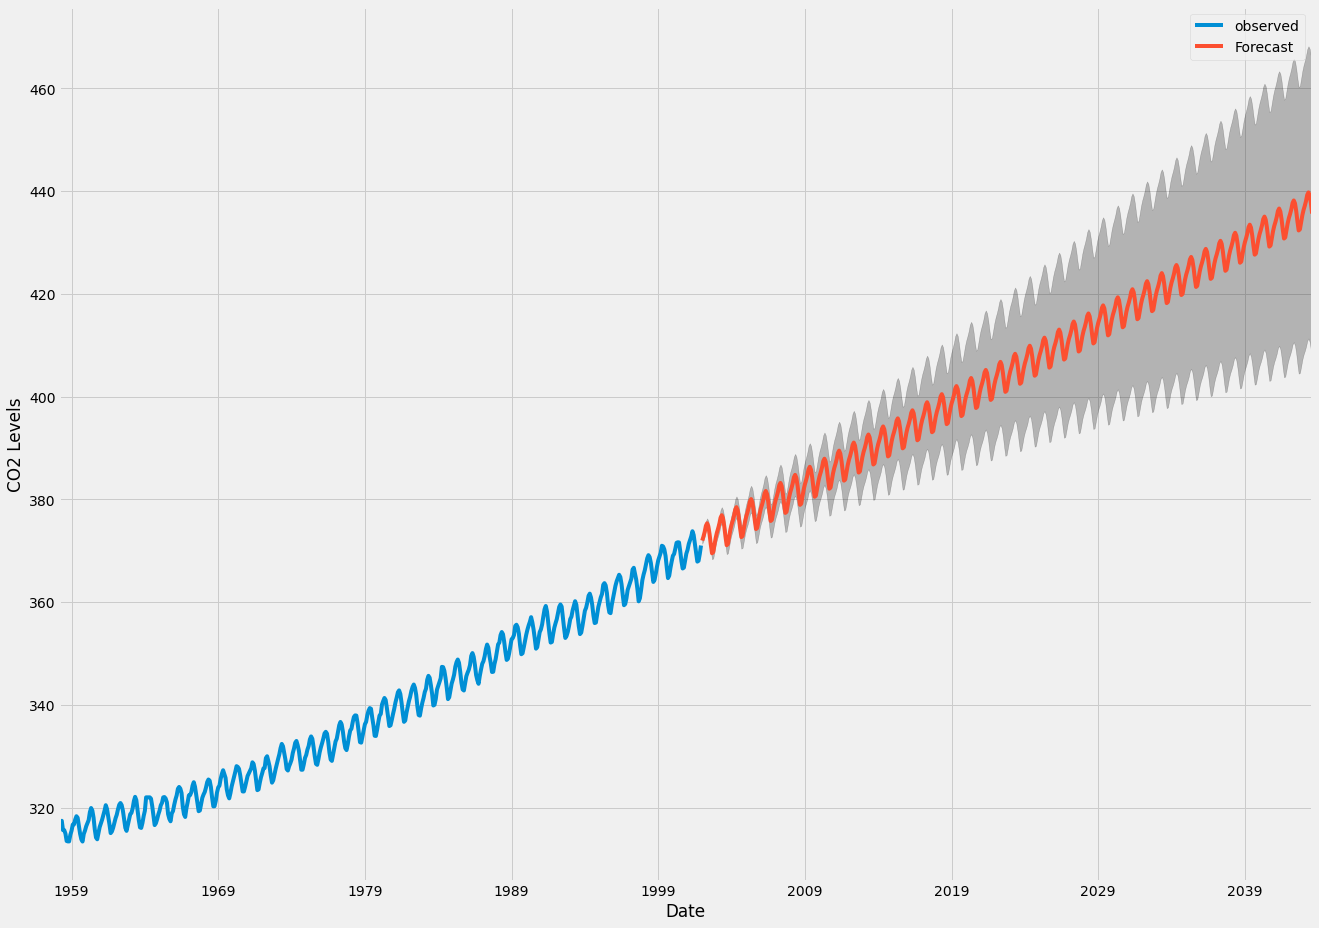

In [31]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()